In [1]:
!pip install vaderSentiment

In [2]:
!pip install nltk

In [3]:
!pip install stop_words

In [4]:
!pip install punkt

ERROR: Could not find a version that satisfies the requirement punkt (from versions: none)
ERROR: No matching distribution found for punkt


# Importing all libraries

In [5]:
import json
import pandas as pd
import numpy as np
import os
import re
import sys
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [6]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, precision_score, recall_score
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import stop_words
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gzip
import pickle
import tensorflow as tf

In [7]:
satisfacton_df = pd.read_csv('Datasets/Survey data_Inflight Satisfaction Score.csv')

In [8]:
satisfacton_df.shape

(47074, 31)

In [9]:
satisfacton_df.describe()

,flight_number,arrival_delay_minutes,number_of_legs,actual_flown_miles
count,47074.000000,47074.000000,47074.000000,47074.000000
mean,1529.855207,-1.702490,1.344118,2477.737732
std,1456.712299,37.868177,0.502424,1865.646538
min,2.000000,-104.000000,1.000000,45.000000
25%,477.000000,-19.000000,1.000000,932.000000
50%,1050.000000,-9.000000,1.000000,1846.000000
75%,2060.000000,4.000000,2.000000,3870.000000
max,6376.000000,907.000000,3.000000,8440.000000


In [10]:
satisfacton_df.head(10)

,flight_number,origin_station_code,destination_station_code,record_locator,scheduled_departure_date,question_text,score,satisfaction_type,driver_sub_group1,driver_sub_group2,...,equipment_type_code,ua_uax,actual_flown_miles,haul_type,departure_gate,arrival_gate,international_domestic_indicator,response_group,media_provider,hub_spoke
0,3802,MKX,ORX,CYXXJJ,9/1/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,...,CRZ,UAX,67,Short,C12,F10,Domestic,non-member,NaN,spoke departure
1,4645,COX,DEX,DRXXMH,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,E75,UAX,72,Short,5,B60,Domestic,member,GOGO,spoke departure
2,5236,COX,DEX,DEXXS1,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,E75,UAX,72,Short,7,A71,Domestic,member,GOGO,spoke departure
3,4686,DEX,COX,PXXXLH,9/1/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,...,CRJ,UAX,72,Short,B82,5,Domestic,member,NaN,hub departure
4,671,DEX,COX,KZXXH5,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,19F,UA,72,Short,B24,3,Domestic,member,PANASONIC,hub departure
5,3947,IAX,CHX,HQXXL6,9/1/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,...,CRZ,UAX,77,Short,A1E,NaN,Domestic,non-member,NaN,hub departure
6,3609,EWX,PHX,DPXXGS,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,E7R,UAX,81,Short,C115,D11R,Domestic,non-member,GOGO,hub departure
7,4797,LAX,SBX,EBXX0S,9/1/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,...,CR7,UAX,89,Short,86B,5D,Domestic,member,GOGO,hub departure
8,5099,LAX,DEX,CDXXLV,9/1/2022,How satisfied were you with the food & beverag...,1,Dissatisfied,food & beverage,food and beverage satisfaction,...,CRJ,UAX,113,Short,1,B54,Domestic,member,NaN,spoke departure
9,4635,ASX,DEX,BNXXXJ,9/1/2022,How satisfied were you with the food & beverag...,3,Dissatisfied,food & beverage,food and beverage satisfaction,...,CR7,UAX,126,Short,3,B55,Domestic,member,GOGO,spoke departure


# EDA

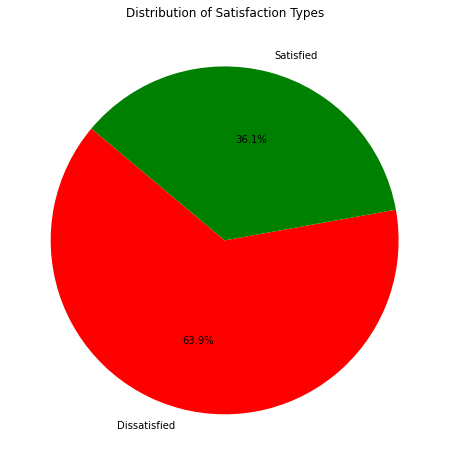

In [15]:
satisfaction_counts = satisfacton_df['satisfaction_type'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(satisfaction_counts, labels=satisfaction_counts.index, autopct='%1.1f%%', startangle=140, colors=['red', 'green'])
plt.title('Distribution of Satisfaction Types')
plt.show()

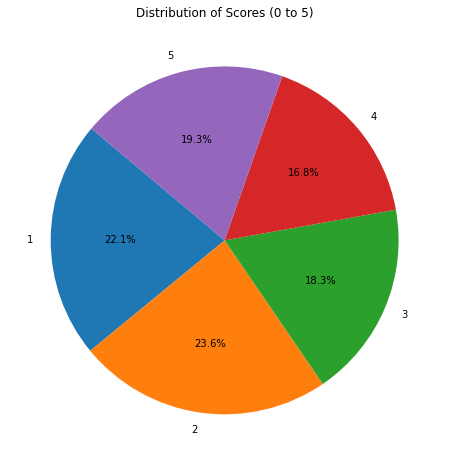

In [23]:
# Filter out values not in the range of 0 to 5
filtered_df = satisfacton_df[(satisfacton_df['score'] >= "0") & (satisfacton_df['score'] <= "5")]

# Calculate the count of each score
score_counts = filtered_df['score'].value_counts().sort_index()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Scores (0 to 5)')
plt.show()

## how delay affected satisafaction score

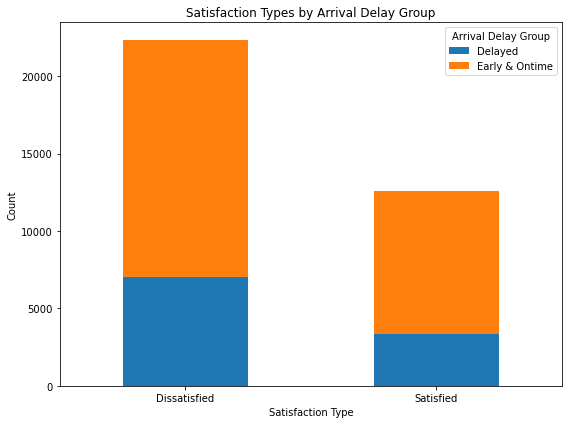

In [24]:
# Count the occurrences of each combination of satisfaction type and arrival delay group
count_df = satisfacton_df.groupby(['satisfaction_type', 'arrival_delay_group']).size().unstack(fill_value=0)

# Plot a grouped bar chart
ax = count_df.plot(kind='bar', stacked=True, figsize=(8, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Satisfaction Type')
ax.set_title('Satisfaction Types by Arrival Delay Group')
plt.xticks(rotation=0)
plt.legend(title='Arrival Delay Group', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

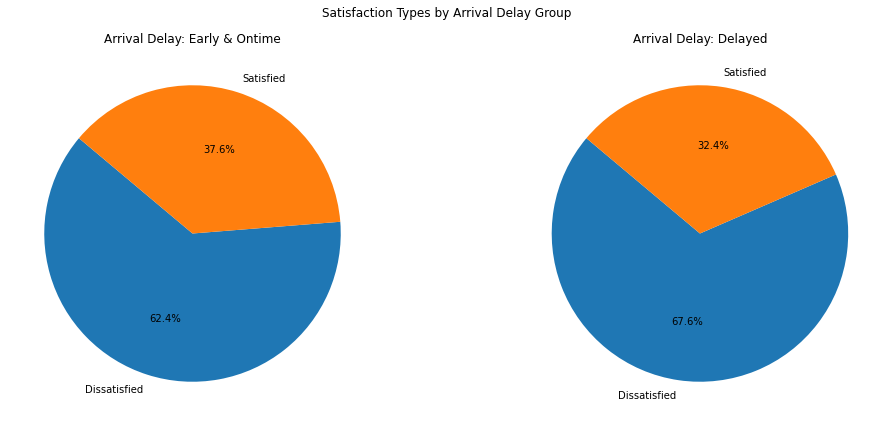

In [25]:
# Group by arrival delay group and satisfaction type, and count occurrences
grouped_counts = satisfacton_df.groupby(['arrival_delay_group', 'satisfaction_type']).size().unstack(fill_value=0)

# Get unique arrival delay groups
delay_groups = satisfacton_df['arrival_delay_group'].unique()

# Create subplots for pie charts
fig, axes = plt.subplots(1, len(delay_groups), figsize=(15, 6))
fig.suptitle('Satisfaction Types by Arrival Delay Group')

# Plot pie charts for each delay group
for i, delay_group in enumerate(delay_groups):
    ax = axes[i]
    counts = grouped_counts.loc[delay_group]
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Arrival Delay: {delay_group}')

plt.tight_layout()
plt.show()

## How satisfaction_type changes with cabin_code_desc

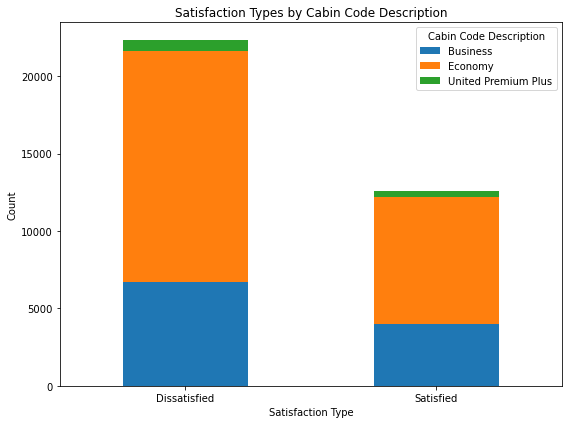

In [27]:
# Count the occurrences of each combination of satisfaction type and cabin code description
count_df = satisfacton_df.groupby(['satisfaction_type', 'cabin_code_desc']).size().unstack(fill_value=0)

# Plot a grouped bar chart
ax = count_df.plot(kind='bar', stacked=True, figsize=(8, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Satisfaction Type')
ax.set_title('Satisfaction Types by Cabin Code Description')
plt.xticks(rotation=0)
plt.legend(title='Cabin Code Description', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

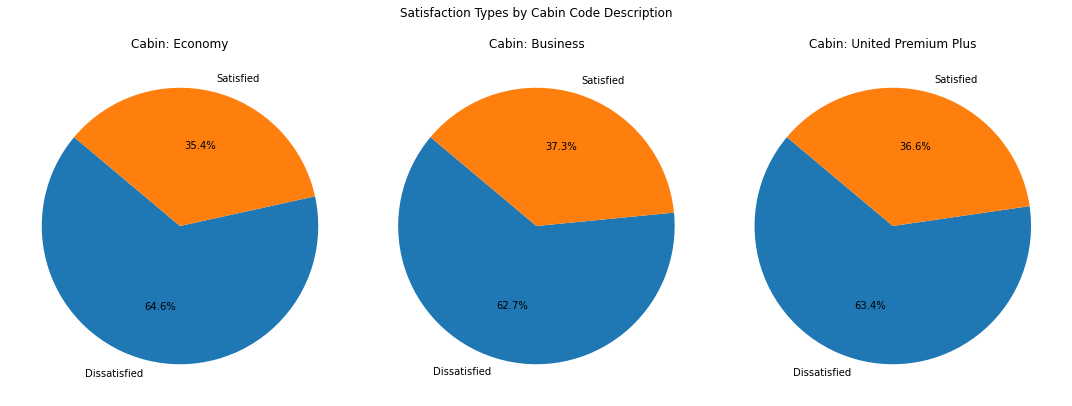

In [29]:
# Get unique cabin code descriptions
cabin_descriptions = satisfacton_df['cabin_code_desc'].unique()

# Create subplots for pie charts
fig, axes = plt.subplots(1, len(cabin_descriptions), figsize=(15, 6))
fig.suptitle('Satisfaction Types by Cabin Code Description')

# Plot pie charts for each cabin description
for i, cabin_desc in enumerate(cabin_descriptions):
    ax = axes[i]
    counts = satisfacton_df[satisfacton_df['cabin_code_desc'] == cabin_desc]['satisfaction_type'].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Cabin: {cabin_desc}')

plt.tight_layout()
plt.show()

## How satisfaction_type changes with generation

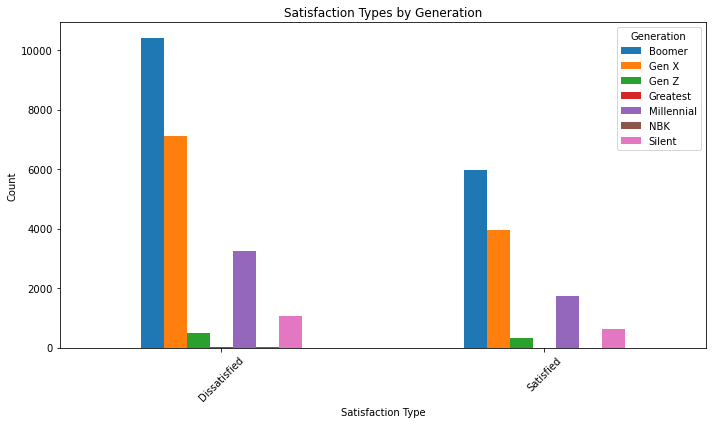

In [30]:
count_df = satisfacton_df.groupby(['satisfaction_type', 'generation']).size().unstack(fill_value=0)

# Plot a bar chart
ax = count_df.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Count')
ax.set_xlabel('Satisfaction Type')
ax.set_title('Satisfaction Types by Generation')
plt.xticks(rotation=45)
plt.legend(title='Generation')
plt.tight_layout()
plt.show()

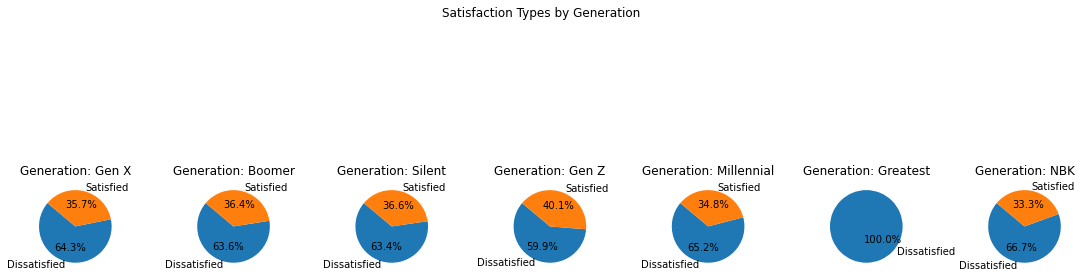

In [31]:
# Get unique generations
generations = satisfacton_df['generation'].unique()

# Create subplots for pie charts
fig, axes = plt.subplots(1, len(generations), figsize=(15, 6))
fig.suptitle('Satisfaction Types by Generation')

# Plot pie charts for each generation
for i, generation in enumerate(generations):
    ax = axes[i]
    counts = satisfacton_df[satisfacton_df['generation'] == generation]['satisfaction_type'].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Generation: {generation}')

plt.tight_layout()
plt.show()